In [8]:
import numpy as np
from Bio import SeqIO
import random
import re
import progressbar
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from optparse import OptionParser
from itertools import cycle



In [9]:
def read_file(file):
    seqs = []
    with open(file,'r') as f:
        for seq in f:
            seqs.append(seq.strip())
    return seqs

def read_files(posfile, negfile):
    pos_seqs = []
    with open(posfile,'r') as f:
        for seq in f:
            pos_seqs.append(seq.strip())
    #This removes the sequences from positive file
    neg_seqs = []
    true_neg = []
    for record in SeqIO.parse(negfile,"fasta"):
        neg_seqs.append(str(record.seq))
    for neg_seq in neg_seqs:
        if not any(pos_seq in neg_seq for pos_seq in pos_seqs):
            true_neg.append(neg_seq)
    #Here, I am taking every 17bp of neg seq as a unit. Ideally, I'd do
    #a permutation of all possible 17bp in the neg seq but it's
    #memory intensive so, I'm trying this first.
    X = []
    k = 0
    for i in true_neg:
        n = 0
        for j in i:
            X.append([])
            X[k].extend(i[n:n+17])
            n += 17
            k += 1
    cut_neg = [s for s in X if len(s) > 16]
    return pos_seqs, cut_neg

def dna_to_vec(sequences):
    Xt = []
    i = 0
    for base in sequences:
        Xt.append([])
        for ch in base:
            if ch == 'A':
                Xt[i].extend([0,0,0,1])
            elif ch == 'T':
                Xt[i].extend([0,0,1,0])
            elif ch == 'G':
                Xt[i].extend([0,1,0,0])
            elif ch == 'C':
                Xt[i].extend([1,0,0,0])
        i += 1
    X = np.array(Xt)
    return X
        

In [10]:
class neuralnet(object):
    
    def __init__(self,inputLayerSize,hiddenLayerSize,outputLayerSize):
        #Adjust the hyperparameter as needed
        self.inputLayerSize = inputLayerSize
        self.hiddenLayerSize = hiddenLayerSize
        self.outputLayerSize = outputLayerSize

        #For weights parameters
        #You need weigh matrix between input and hidden layer, and also between
        #hidden and output layer. For now, they are just random values now.
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        self.bias1 = np.random.randn(1,self.hiddenLayerSize)
        self.bias2 = np.random.randn(1,self.outputLayerSize)

    def forward(self,X):
    	#This is a feedforward function, where you estimate the output
    	#using the weigh matrix and activation function in each layer.
        
        self.z2 = np.dot(X,self.W1) + self.bias1
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2,self.W2) + self.bias2
        yHat = self.sigmoid(self.z3)
        return yHat

    def sigmoid(self, z):
    	#This is one type of activation function that we are using.
        return 1/(1+np.exp(-z))

    def sigmoidPrime(self,z):
    	#This is derivative of sigmoid function. This is needed to calculate
    	#gradient descent.
        return np.exp(-z)/((1+np.exp(-z))**2)

    def costFunction(self, X, y, lam):
        '''
        J tells you what the difference is between the predicted and actual result.
        Compute cost for given X,y, use weights already stored in class.
        To avoid overfitting, we add a regularization paramter, lam to our cost function.
        The higher the lam value, the bigger the penalties impose.

        '''
        m = len(X[0])
        self.yHat = self.forward(X)

        J = (1/m) * np.sum((y - self.yHat)**2) + ((lam/2) * (np.sum(self.W2**2) + np.sum(self.W1**2)))
        
        return J

    def costFunctionPrime(self, X, y):
        #To get a batch gradient descent, we need to do more derivatives.
        self.yHat = self.forward(X)
        #We need to add lam to make sure we are not overfitting
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)

        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)
        dJdb1 = delta2
        dJdb2 = delta3

        return dJdW1, dJdW2, dJdb1, dJdb2

    def train(self,X,y,iterations,alpha,lam):
        self.X = X
        self.y = y
        m = X.shape[0]
        bar = progressbar.ProgressBar(maxval=iterations,widgets=[progressbar.Bar('=','[',']'),' ', progressbar.Percentage()])
        bar.start()
        count=0
        for i in range(0,iterations):
            count +=1
            bar.update(i+1)
            #Reset parameters at each iteration.
            #And do more PDE until you can't do anymore.
            dW1 = np.zeros((self.inputLayerSize,self.hiddenLayerSize))
            dW2 = np.zeros((self.hiddenLayerSize,self.outputLayerSize))
            db1 = np.zeros((1,self.hiddenLayerSize))
            db2 = np.zeros((1,self.outputLayerSize))
            dJdW1,dJdW2,dJdb1,dJdb2 = self.costFunctionPrime(X,y)
            dW1 += dJdW1
            dW2 += dJdW2
            for j in range(0,(m-1)):
                db1 += dJdb1[j]
                db2 += dJdb2[j]
            #Altering the parameters
            self.W1 = self.W1 - alpha*(((1/m)*dW1)+lam*self.W1)
            self.W2 = self.W2 - alpha*(((1/m)*dW2)+lam*self.W2)
            self.bias1 = self.bias1 - alpha*((1/m)*db1)
            self.bias2 = self.bias2 - alpha*((1/m)*db2)
        bar.finish()
        print('Score:')
        print(self.costFunction(X,y,lam))
        return self.forward(X)

    #The following functions test for a single example
    def forward_stochastic(self,X,k):
    	#This is a feedforward function, where you estimate the output
    	#using the weigh matrix and activation function in each layer.
        self.z2 = np.dot(X[k],self.W1) + self.bias1
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2,self.W2) + self.bias2
        yHat = self.sigmoid(self.z3)
        return yHat
    
    def costFunction_stochastic(self,X,y,k,lam):
        m = len(X[0])
        self.yHat_s = self.forward_stochastic(X,k)
        J = np.sum((y[k] - self.yHat_s)**2) + ((lam/2) * (np.sum(self.W2**2) + np.sum(self.W1**2)))
        return J

    def costFunctionPrime_stochastic(self, X, y,k):
        #To get a batch gradient descent, we need to do more derivatives.
        self.yHat = self.forward_stochastic(X,k)
        #We need to add lam to make sure we are not overfitting
        delta3 = np.multiply(-(y[k]-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3,self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X[k].T.reshape(self.inputLayerSize,1),delta2)
        dJdb1 = delta2
        dJdb2 = delta3

        return dJdW1, dJdW2, dJdb1, dJdb2

    def train_stochastic(self,X,y,iterations,alpha,lam,pos_len,neg_len):
        self.X = X
        self.y = y
        m = X.shape[0]
        pos, neg = 0,0
        bar = progressbar.ProgressBar(maxval=iterations,widgets=[progressbar.Bar('=','[',']'),' ', progressbar.Percentage()])
        bar.start()
        for i in range(0,iterations):
            bar.update(i+1)
            #Generate a random number to see the index which dataset to use.
            #Get the index of pos_vec if it's > 0.3.
            #If less, use that of negative.
        rand = random.uniform(0,1) # This is the random number that determines whether positive or negative data will be used this iteration.
        if rand > 0.3:
            rand2 = random.randint(0,pos_len-1) # If it's greater than 0.3, use positive data.
        else:
            rand2 = random.randint(pos_len,neg_len) # If less, use negative.
        # Positive vs negative data is determined by the index of the numpy array. The way the data is set up, positive data comes before neagtive.

        new_costfunc = self.costFunction_stochastic(X,y,rand2,lam)
        new_alpha = (2*alpha * new_costfunc) + alpha #Use cost function value to alter alpha.
        # Set update matrices to zero each iteration
        dW1 = np.zeros((self.inputLayerSize,self.hiddenLayerSize))
        dW2 = np.zeros((self.hiddenLayerSize,self.outputLayerSize))
        db1 = np.zeros((1,self.hiddenLayerSize))
        db2 = np.zeros((1,self.outputLayerSize))

        # Find partial derivatives
        dJdW1,dJdW2,dJdb1,dJdb2 = self.costFunctionPrime_stochastic(X,y,rand2)
        # Update "change" matrices
        dW1 += dJdW1
        dW2 += dJdW2
        db1 += dJdb1
        db2 += dJdb2

        # And finally, update the weight and bias matrices. Since they are class objects, these will be stored outside of this function for use with test data.
        self.W1 = self.W1 - new_alpha*(((1/m) * dW1) + lam * self.W1)
        self.W2 = self.W2 - new_alpha*(((1/m) * dW2) + lam * self.W2)
        self.bias1 = self.bias1 - new_alpha*((1/m) * db1)
        self.bias2 = self.bias2 - new_alpha*((1/m) * db2)
        bar.finish()
        print('Score:')
        return self.forward(X)

In [11]:
#Reading in data
posfile='rap1-lieb-positives.txt'
negfile='yeast-upstream-1k-negative.fa'
pos_seqs, cut_neg = read_files(posfile, negfile)
pos_vec, neg_vec = dna_to_vec(pos_seqs),dna_to_vec(cut_neg)

In [45]:
#Creating datasets for cross-validation by shuffling positive datasets
avgC = int(round(pos_vec.shape[0]/5))
np.random.shuffle(pos_vec)
pos_a = pos_vec[:avgC]
pos_b = pos_vec[avgC:2*avgC]
pos_c = pos_vec[2*avgC:3*avgC]
pos_d = pos_vec[3*avgC:4*avgC]
pos_e = pos_vec[4*avgC:]
pos_list =[pos_a,pos_b,pos_c,pos_d,pos_e]
#Creating output datasets
y_a = np.ones((pos_a.shape[0],1))
y_b = np.ones((pos_b.shape[0],1))
y_c = np.ones((pos_c.shape[0],1))
y_d = np.ones((pos_d.shape[0],1))
y_e = np.ones((pos_e.shape[0],1))
y_list = [y_a,y_b,y_c,y_d,y_e]

#Repeat the same thing for negative datasets
avgK = int(round(neg_vec.shape[0]/5))
np.random.shuffle(neg_vec)
neg_a = neg_vec[:avgK]
neg_b = neg_vec[avgK:2*avgK]
neg_c = neg_vec[2*avgK:3*avgK]
neg_d = neg_vec[3*avgK:4*avgK]
neg_e = neg_vec[4*avgK:]
neg_list =[neg_a,neg_b,neg_c,neg_d,neg_e]
#Creating prediction output datasets
yhat_a = np.zeros((neg_a.shape[0],1))
yhat_b = np.zeros((neg_b.shape[0],1))
yhat_c = np.zeros((neg_c.shape[0],1))
yhat_d = np.zeros((neg_d.shape[0],1))
yhat_e = np.zeros((neg_e.shape[0],1))
yhat_list = [yhat_a,yhat_b,yhat_c,yhat_d,yhat_e]

[========================================================================] 100%


Score:


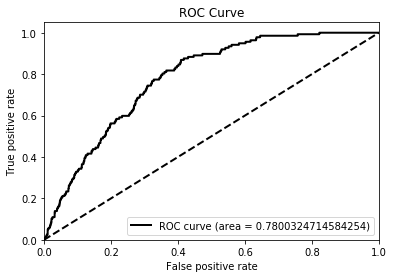

AAAAAAACGCAACTAAT	[0.0018429]	
AAAAACACACATCTGGC	[0.41741983]	
AAAACCAAACACCTGAA	[0.06497066]	
AAAACCAAACAGCTCAG	[0.079775]	
AAAACCAAACATATCAA	[0.9670479]	
AAAACCAAACATATCAA	[0.9670479]	
AAAACCACACACATCGC	[0.91429038]	
AAAACCACACCTTGTAT	[0.00887628]	
AAAACCAGACATACTAA	[0.07611051]	
AAAACCAGACCCTTTAC	[0.28518177]	
AAAACCAGGCACCAAGG	[0.04782509]	
AAAACCATACACATTCG	[0.95024332]	
AAAACCATAGACTTCTC	[0.96775113]	
AAAACCATCCATCCTGT	[0.93181976]	
AAAACCATGCAGTTCTT	[0.50689067]	
AAAACCATGCCGTTGAA	[0.12654376]	
AAAACCATTCCCAACAA	[0.9347541]	
AAAACCTTACATTGTTC	[0.79686468]	
AAAAGCACGCATCCGGC	[0.68582347]	
AAAAGCACGCATCCGGC	[0.68582347]	
AAAAGCATACCCCGCAC	[0.71896165]	
AAAAGCATGCACCTTGC	[0.99964033]	
AAAATCATACATTTCCA	[0.95594161]	
AAAATCATACATTTCGG	[0.99451621]	
AAACACACAAACGCCAG	[0.6760041]	
AAACACACAAACGCCAG	[0.6760041]	
AAACACACACACACAAA	[0.0249654]	
AAACACACACACTCACC	[0.23495593]	
AAACACAGATACCTCGA	[0.99532717]	
AAACACATACACCTTAA	[0.79286589]	
AAACACATACATTACCA	[0.96584931]	
AAACACATGCACGCCAC

ACGCCCGGGCCTTTCTC	[0.99996343]	
ACGCCCGGGCCTTTCTC	[0.99996343]	
ACGCCCGTGCCCCGCGA	[0.96717371]	
ACGCCCTGACCTATCTC	[0.99994395]	
ACGCCCTGCCATACCAG	[0.9903314]	
ACGCCCTTTCCCCTCAA	[0.9997491]	
ACGCCGAAACCCCCTCC	[0.05501015]	
ACGCTCAAGCATCACAA	[0.85977188]	
ACGCTCAGACATCTACA	[0.92188972]	
ACGCTCATACTCTTTAT	[0.22545681]	
ACGCTCATGCCTCAAAA	[0.37731377]	
ACGCTCATGTACTTCTT	[0.09508375]	
ACGCTGGAACACCAGAT	[0.16136143]	
ACGGCCACACAGTCAAT	[0.00137518]	
ACGGCCATGCAATTGGC	[0.82074441]	
ACGGTCACGCATCCGCA	[0.00023743]	
ACGGTCACGCATCCGCA	[0.00023743]	
ACGTACACGCATCAGAA	[0.00010583]	
ACGTACATAGACCCTTG	[0.00432165]	
ACGTACATATACATCAA	[0.94765329]	
ACGTATATACATTCCAA	[0.96439317]	
ACGTCAACAAACCTGGC	[0.19856016]	
ACGTCAATAAACTCCAA	[0.01799583]	
ACGTCAGTACCCCTCCA	[0.99092028]	
ACGTCCACTCCTTTCAC	[0.82258562]	
ACGTCCAGCCACCCATT	[0.1783649]	
ACGTCCAGGTACTCAGT	[0.00522207]	
ACGTCCATAAACCGTAA	[0.05080579]	
ACGTCCATACAATTGAG	[0.64546345]	
ACGTCCATACTGCTTAG	[0.69873053]	
ACGTCCATACTGCTTAG	[0.69873053]	
ACGTCCATGCA

GAATCCAAACCTTTAGA	[0.99791594]	
GAATCCAAACTCCAAGG	[0.02050573]	
GAATCCAAATCTCTCAA	[0.99894103]	
GAATCCAAGCAATTCAT	[0.86657806]	
GAATCCAAGCATACTCC	[0.99232974]	
GAATCCACAGACCAAAT	[0.01127921]	
GAATCCACATACTTTCT	[0.00770411]	
GAATCCACTAACTCCAA	[0.05119604]	
GAATCCAGACAACATCA	[0.95930548]	
GAATCCAGCCCTTTCGT	[0.99849971]	
GAATCCATACCGCCCAA	[0.9250808]	
GAATCCATACGACCTCT	[0.7980983]	
GAATCCATACGCCACCC	[0.87855112]	
GAATCCATATATTTAAC	[0.99989222]	
GAATCCATCAACAAGAG	[0.23048937]	
GAATCCATCCACAGCGT	[0.98819638]	
GAATCCATCTCCTCTTC	[0.99976489]	
GAATCCATGAAACTCAT	[0.99944501]	
GAATCCATGGACCAAGA	[0.98638012]	
GAATCCATTCACTTATA	[0.98424466]	
GAATCCCCACACCTTCC	[0.9898016]	
GAATCCCGACATGCCAC	[0.99991863]	
GAATCCGCCCATAGGCA	[0.87067334]	
GAATCCGTACAATCAGT	[0.85583209]	
GAATCCGTACAATGCGA	[0.99500827]	
GAATCCGTACCCTTTAT	[0.97871003]	
GAATCCGTGCGTTCCAT	[0.95992326]	
GAATCCGTTCCCTCCAA	[0.99608872]	
GAATCCTTGCCCATCAG	[0.99994616]	
GAATCCTTGCCCGTCAG	[0.99997235]	
GAATCCTTGTCCTCCAA	[0.99972492]	
GAATCGATCCC

GTGTACATACATTATTC	[0.57215463]	
GTGTCCAAATACCAGGA	[0.39700192]	
GTGTCCATGACCTTAGG	[0.02712009]	
GTGTCCATGCACTTTAA	[0.8033828]	
GTGTCCATTCACTCATA	[0.41623179]	
GTGTCCATTCATCTCAT	[0.9848553]	
GTGTCCGTGCATAACGA	[0.99843383]	
GTGTCCTTGTACTTCAA	[0.9993882]	
GTGTCTATACACCTGGT	[0.06404061]	
GTGTGCAAACACCAGCT	[1.67655706e-05]	
GTGTGCAAACACCAGCT	[1.67655706e-05]	
GTGTGCAAACCTTCGTC	[0.95458301]	
GTGTGCATATCCTCGTA	[0.80573385]	
GTGTTCATAAACGTGGT	[0.87120051]	
GTTCCCGAACACTCCTC	[0.99156459]	
GTTGCCATACACTATGT	[0.01213428]	
GTTTCCAAACCTCCCAA	[0.76802084]	
GTTTCCACACCCGTGAT	[0.08472467]	
GTTTCCATTCACTTCAC	[0.99354464]	
GTTTCCGCGCACCTTTT	[0.50924188]	
TAAACAATACACTTTAA	[0.01530439]	
TAAACCAAAAACCACGA	[0.01281277]	
TAAACCAAACACAGGAA	[0.00092116]	
TAAACCAGAGACTCCGA	[0.01324495]	
TAAACCATTCATTACAC	[0.61276179]	
TAACACAAACAACTTGC	[0.99613946]	
TAACACAAGCATCCAAA	[0.96929409]	
TAACACATGCTCTTCCA	[0.97946613]	
TAACACATTAACTCGAA	[0.18108582]	
TAACCAAAGCACTCCAA	[0.04182811]	
TAACCAGTACCTAGGCT	[0.25131763]	
TAA

TTACCCGGACCTTACGA	[0.99759386]	
TTACCGATACATTCCGT	[0.62804272]	
TTACGCATGAACTCGTA	[0.02100826]	
TTACTCAGGCCCTTGTC	[0.92115051]	
TTACTCATACAACTCAA	[0.99444798]	
TTACTCGTGCACGCAAA	[0.99899537]	
TTAGCCAAGGACCCCAT	[0.05875747]	
TTATACACACATTCAAA	[0.22904134]	
TTATACACGCACTTCTA	[0.73504047]	
TTATACGTACATTTGGC	[0.99974056]	
TTATCCAAACCTTCCGT	[0.16978252]	
TTATCCAAACTTTTGGA	[0.66878036]	
TTATCCAAATACTACGA	[0.81548292]	
TTATCCAAGCCCAAGAA	[0.07416456]	
TTATCCAATTACCTCAA	[0.71682291]	
TTATCCAATTACCTCAA	[0.71682291]	
TTATCCAATTACTTCTA	[0.71178707]	
TTATCCACAAACTTTAA	[0.00743155]	
TTATCCATAACGTTCGA	[0.44743145]	
TTATCCATACATTCCAT	[0.88874707]	
TTATCCATATACCTTAT	[0.42508516]	
TTATCCATCCACCAGTC	[0.48145697]	
TTATCCATGCAACCAAG	[0.2346459]	
TTATCCGGACCCTACAT	[0.39936693]	
TTATGCATAGCCCTCTT	[0.02480105]	
TTATGCATGACCTCTGG	[0.02928363]	
TTATGCATTAACTTGAA	[0.12139148]	
TTATGCATTCACTTGAG	[0.2521605]	
TTATGCATTCACTTGAG	[0.2521605]	
TTATTCAAACCTCAGAA	[0.08833654]	
TTATTCAAGCCCTCCAG	[0.0066717]	
TTATTCATACTC

In [58]:
nn = neuralnet(68,200,1)
pos = np.concatenate(pos_list)
neg = np.concatenate(neg_list)
y = np.concatenate(y_list)
yhat = np.concatenate(yhat_list)
Xtrain = np.concatenate((pos,neg))
ytrain = np.concatenate((y,yhat))
y_hat = nn.train_stochastic(Xtrain,ytrain,100,10,0, pos.shape[0],neg.shape[0]) 

#Generating ROC curve.
fpr,tpr, treshold = roc_curve(ytrain,y_hat, pos_label=1) # This is for regular ROC
plt.figure()
roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr,color = 'black',lw = 2,label = 'ROC curve (area = {})'.format(roc_auc))
plt.plot([0,1],[0,1],'k--',lw=2)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = "lower right")
plt.show()

Xtest = read_file("rap1-lieb-test.txt") # Testing dataset
Xtest_vec = dna_to_vec(Xtest)
yhat_test = nn.forward(Xtest_vec) # Run data through NN
# Save data to text file

with open("yhat_test_snow.txt", "w") as f:
    for i, seq in enumerate(Xtest):
        print (seq + "\t" + str(yhat_test[i]) + "\t")
        f.write(seq)
        f.write("\t")
        f.write(str(yhat_test[i]))
        f.write("\t")

Training dataset 1


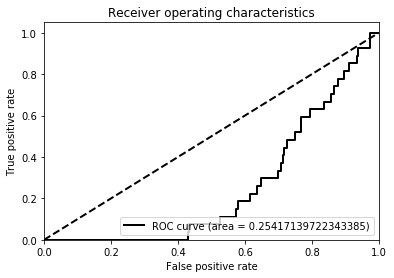

Training dataset 2


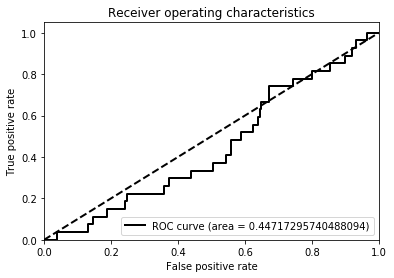

Training dataset 3


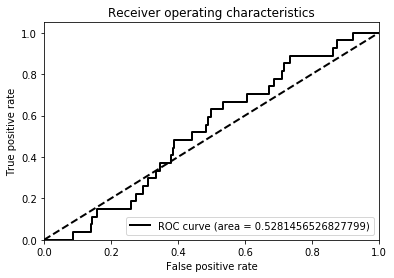

Training dataset 4


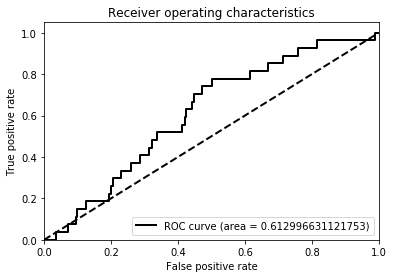

Training dataset 5


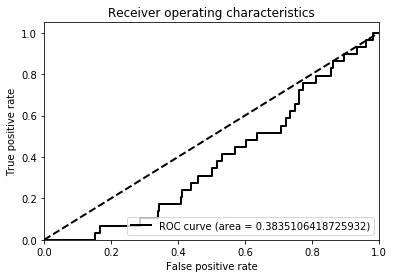

In [59]:
for i in range(0,5):
    print("Training dataset {}".format(i+1))
    nn.__init__(68,200,1) # Reinitialize the neural network class so that each withheld dataset gets a fresh neural net.
    # Choose withheld dataset based on i.
    pos_test = pos_list[i]
    neg_test = neg_list[i]
    y_test = y_list[i]
    yhat_test = yhat_list[i]
    Xtrainlistpos = []
    Xtrainlistneg = []
    ytrainlistpos = []
    ytrainlistneg = []
    for j in range(0,5):
        if j != i:
            # Choose training dataset (all j for j !=i)
            Xtrainlistpos.append(pos_list[j])
            Xtrainlistneg.append(neg_list[j])
            ytrainlistpos.append(y_list[j])
            ytrainlistneg.append(yhat_list[j])

    Xtrainpos = np.concatenate(Xtrainlistpos)
    Xtrainneg = np.concatenate(Xtrainlistneg)
    ytrainpos = np.concatenate(ytrainlistpos)
    ytrainneg = np.concatenate(ytrainlistneg)
    Xtrain = np.concatenate((Xtrainpos,Xtrainneg))
    ytrain = np.concatenate((ytrainpos,ytrainneg))

    Xtest = np.concatenate((pos_test,neg_test))
    ytest = np.concatenate((y_test,yhat_test))
    # Get scores from nn.forward for test dataset, then generate and ROC curve.
    scores = nn.forward(Xtest)
    fpr,tpr,thresholds = metrics.roc_curve(ytest,scores)
    roc_auc = metrics.auc(fpr,tpr)
    lw = 2
    colors = cycle(['aqua','darkorange','cornflowerblue','darkred','black'])

    plt.plot(fpr,tpr,color = 'black',lw = lw,label = 'ROC curve (area = {})'.format(roc_auc))
    plt.plot([0,1],[0,1],'k--',lw=lw)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristics')
    plt.legend(loc = "lower right")
    plt.show()
